In [1]:
# import librabries
import sqlite3
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud

import numpy as np
import re
import matplotlib.pyplot as plt



In [2]:
#Connect to the database
con = sqlite3.connect(r"C:\Users\20211090\OneDrive\Desktop\database.db")

query_klm = '''
    SELECT text, user_id, lang
    FROM KLM_tweets 
'''
df_klm = pd.read_sql_query(query_klm, con)


df_klm



,text,user_id,lang
0,@Pelusitaaaa1 Hoi! Enkel KLM/Air France-vluch...,56377143,nl
1,@Pelusitaaaa1 We helpen je graag. Kan je ons e...,56377143,nl
2,@addblackman We understand that you would pref...,56377143,en
3,@CarlosMosig Con el fin de evitar errores noso...,56377143,es
4,@addblackman We do understand that some passen...,56377143,en
...,...,...,...
5017,Ã‚Â¡Ya vamos para Calella para hacer la activi...,749515688696483844,es
5018,Home of Royal Dutch Airlines @KLM,31592791,en
5019,@kjwoerkom @luchtvaart @KLM @tudelft Hij vlieg...,264190654,nl
5020,RT @SpaethFlies: V-shaped Flying Wing concept ...,759460420352630788,en


In [3]:
# change user-id from str to int
df_klm = df_klm.astype({
    'text' : 'str',
    'user_id' : 'int64'                 
}) 


In [4]:
type(df_klm.user_id[0])

numpy.int64

In [5]:
# drop KLM reply tweets and non_English tweets => so that we analyze only customers tweets in English
df_textblob = df_klm[(df_klm.user_id != 56377143) & (df_klm.lang == 'en')] 

df_textblob

,text,user_id,lang
921,RT @McWhirterAlex: .@KLM will fly Amsterdam-Ba...,1328529979,en
922,RT @Vinamralongani: @KLM to launch thrice week...,1328529979,en
923,@wolfmandanny @KLM Thanks Dan,2409245946,en
925,@KLM Aviation releases about 3% of human carbo...,1109522354206584833,en
926,#worstserviceever DO NOT FLY EVER AGAIN @AirFr...,56459096,en
...,...,...,...
5010,"@KLM Thanks, I already went through this list ...",538129774,en
5011,@MadelineDarveau @KLM Hi Maddie. I sincerely a...,5920532,en
5013,"@KLM Thank you, but I've contacted you guys al...",1918871,en
5018,Home of Royal Dutch Airlines @KLM,31592791,en


In [6]:
# cleaning text

# define a function to prepocess the text (for KLM). 
def preproc_text(text):
    text = re.sub(r'@[^\s]+','',text) #remove quote
    text = re.sub(r'RT[\s]+',' ',text) #remove retweet
    text = re.sub(r'http\S+',' ',text) #remove hyperlink
    text = re.sub(r'www.\S+','',text) # remove web link
    text = re.sub(r'#[A-Za-z0-9_]+','',text) # remove hashtag
    text = re.sub(r'[()!?]','',text) #remove exlamation marks
    remove_list= 'Ã'+'Â'+'±'+'ã'+'¼'+'â'+'»'+'§'
    remove_list= 'Ã'+'Â'+'±'+'ã'+'¼'+'â'+'»'+'§'+ '¢‚¬¦'+ 'Å¸€¡³°Å¸€¡' + '¢‚¬Å¾'
    table = str.maketrans('', '', remove_list)
    text = text.translate(table)
    
    text = text.split()
    del_words = ['for','of','and','to','from','on','in','at','a','an','the','am','will','would','was','were','shall']
    text = [word for word in text if not word in del_words] #remove stopwords
    text = ' '.join(word for word in text)
    return text
  
df_textblob['text'] = df_textblob['text'].apply(preproc_text)
df_textblob

<ipython-input-6-756f9c6db631>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_textblob['text'] = df_textblob['text'].apply(preproc_text)


,text,user_id,lang
921,. fly Amsterdam-Bangalore now that Jet Airways...,1328529979,en
922,launch thrice weekly service Amsterdam using a...,1328529979,en
923,Thanks Dan,2409245946,en
925,Aviation releases about 3% human carbon emissi...,1109522354206584833,en
926,DO NOT FLY EVER AGAIN OR How is one person alo...,56459096,en
...,...,...,...
5010,"Thanks, I already went through this list „š. S...",538129774,en
5011,Hi Maddie. I sincerely apologize any inconveni...,5920532,en
5013,"Thank you, but I've contacted you guys already...",1918871,en
5018,Home Royal Dutch Airlines,31592791,en


In [7]:
# df_klm


In [8]:
# define a function to get subjectivity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity # how subjectivity the opinion is

# define a function to get polarities

def get_polarity(text):
    return TextBlob(text).sentiment.polarity # how positive or negative is the text

df_textblob['subjectivity'] = df_textblob['text'].apply(get_subjectivity)
df_textblob['polarity'] = df_textblob['text'].apply(get_polarity)

<ipython-input-8-54039ca283c0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_textblob['subjectivity'] = df_textblob['text'].apply(get_subjectivity)
<ipython-input-8-54039ca283c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_textblob['polarity'] = df_textblob['text'].apply(get_polarity)


In [9]:
#define a function to analyze the score to levels
def analysis(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_textblob['analysis'] = df_textblob['polarity'].apply(analysis)


df_textblob.tail(50)

<ipython-input-9-1c59e445a0cf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_textblob['analysis'] = df_textblob['polarity'].apply(analysis)


,text,user_id,lang,subjectivity,polarity,analysis
4925,"Next year„s be hosted Amsterdam June 21-23, 20...",1001001432,en,0.000000,0.000000,Neutral
4926,To our amazing crew around world: Happy Intern...,451748347,en,0.575000,0.400000,Positive
4930,Luv Archimedian solid.,857043422963564544,en,0.100000,0.000000,Neutral
4932, CEO Pieter Elbers be host next years Amsterd...,150704748,en,0.000000,0.000000,Neutral
4933, CEO Pieter Elbers be host next years Amsterd...,3010831688,en,0.000000,0.000000,Neutral
4934, CEO Pieter Elbers be host next years Amsterd...,1079913051678216193,en,0.000000,0.000000,Neutral
4936, CEO Pieter Elbers be host next years Amsterd...,84256326,en,0.000000,0.000000,Neutral
4938,Hey - you lost one our bags enroute ATL-CPH We...,190809813,en,0.000000,0.000000,Neutral
4939, CEO Pieter Elbers be host next years Amsterd...,362431100,en,0.000000,0.000000,Neutral
4943,having luggage problem more than 24 hours,2199740099,en,0.500000,0.500000,Positive


In [10]:
df_textblob['text'][5000] # manually checked, this tweet should be label 'Negative' rather than Neutral as Textblob analysed

'HAMKL24050 HAVE NOT RECEIVED MY BAGS FROM THE FLIGHT'

In [11]:
df_textblob.head(10)

,text,user_id,lang,subjectivity,polarity,analysis
921,. fly Amsterdam-Bangalore now that Jet Airways...,1328529979,en,0.900000,0.800000,Positive
922,launch thrice weekly service Amsterdam using a...,1328529979,en,0.000000,0.000000,Neutral
923,Thanks Dan,2409245946,en,0.200000,0.200000,Positive
925,Aviation releases about 3% human carbon emissi...,1109522354206584833,en,0.633333,0.533333,Positive
926,DO NOT FLY EVER AGAIN OR How is one person alo...,56459096,en,0.500000,-0.200000,Negative
927,I don't know why BA have these old planes our ...,94425945,en,0.511111,0.200000,Positive
928,DO NOT FLY EVER AGAIN OR How is one person alo...,56459096,en,0.500000,-0.200000,Negative
929,I don't know why BA have these old planes our ...,5404442,en,0.511111,0.200000,Positive
930,The collapse has prompted its former partners ...,16653237,en,0.227273,0.068182,Positive
932,What beautiful healthy breakfast packed full n...,762396998532231169,en,0.683333,0.566667,Positive


Text(0, 0.5, 'subjectivity')

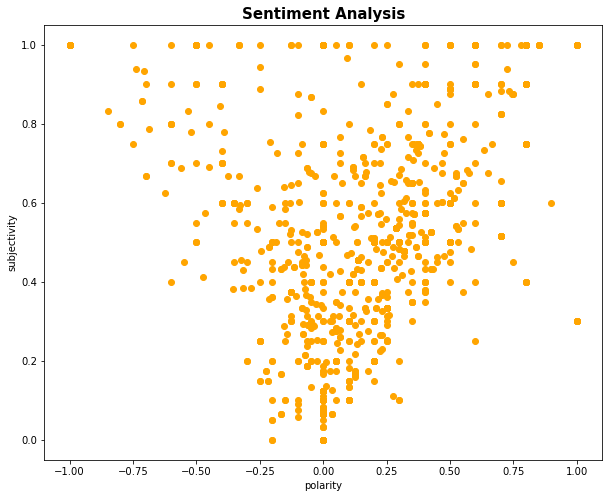

In [12]:
#print(df_textblob['polarity'][0])

plt.figure(figsize=(10,8))
for index, row in df_textblob.iterrows():
    plt.scatter(row['polarity'],row['subjectivity'], color = 'orange')
    
plt.title('Sentiment Analysis', fontsize= 15, fontweight='bold')
plt.xlabel('polarity')
plt.ylabel('subjectivity')


In [13]:
df_textblob['analysis'].value_counts()

Neutral     814
Positive    792
Negative    256
Name: analysis, dtype: int64

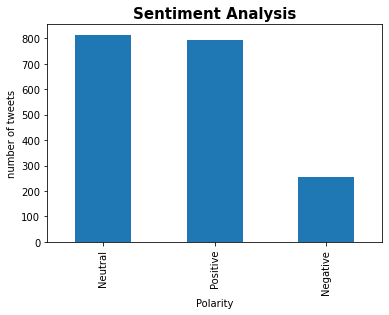

In [14]:
# Sentiment Distribution Plot

plt.title('Sentiment Analysis', fontsize= 15, fontweight='bold')
plt.xlabel('Polarity')
plt.ylabel('number of tweets')
df_textblob['analysis'].value_counts().plot(kind ='bar')
plt.show()

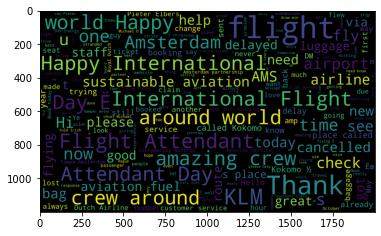

In [15]:

#textcloud visualization to get key-words

words = ' '.join([text for text in df_textblob['text']])
text_cloud = WordCloud( width = 2000, height = 1200, random_state = 25, max_font_size = 180).generate(words)
plt.imshow(text_cloud)
plt.show()